In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [3]:
# we will start simple with a single fully-connected neural layer as encoder and decoder
# this is the siez of our encoded representations
ENCODING_DIM = 32

# input placeholder
input_img = tf.keras.layers.Input(shape=(784,))

# this is the encoded representation of the input
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)

# this is the loss reconstruction of the input
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its recommendation
autoencoder = tf.keras.models.Model(input_img, decoded)

In [4]:
# let's also create a seprate encoder model
# this mode maps an input to its encoded representation
encoder = tf.keras.models.Model(input_img, encoded)

In [5]:
# as well as decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

In [6]:
# Now let's train our autoencoder to reconstruct MNIST digits
# first we will configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [7]:
# let's prepare our input data. We are using MNIST digits and we are disregrading the labels (since we are only interested in encoding/decoding the input images)
# load the data
(x_train, _), (x_test, _) = load_data('mnist.npz')

In [8]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [9]:
# now let's train our autoencoder for 50 epochs
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 6s 14ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 2/50
235/235 [==============================] - 2s 10ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 3/50
235/235 [==============================] - 2s 10ms/step - loss: 0.6922 - val_loss: 0.6922
Epoch 4/50
235/235 [==============================] - 2s 11ms/step - loss: 0.6921 - val_loss: 0.6920
Epoch 5/50
235/235 [==============================] - 3s 11ms/step - loss: 0.6919 - val_loss: 0.6918
Epoch 6/50
235/235 [==============================] - 2s 11ms/step - loss: 0.6917 - val_loss: 0.6917
Epoch 7/50
235/235 [==============================] - 2s 10ms/step - loss: 0.6916 - val_loss: 0.6915
Epoch 8/50
235/235 [==============================] - 3s 11ms/step - loss: 0.6914 - val_loss: 0.6913
Epoch 9/50
235/235 [==============================] - 3s 11ms/step - loss: 0.6912 - val_loss: 0.6912
Epoch 10/50
235/235 [==============================] - 3s 11ms/step - loss: 0.6911 - val_lo

In [10]:
# after 50 epochs the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will be using Matplotlib
# encode and decode some digits
# note that we take them from the "test" set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 4ms/step


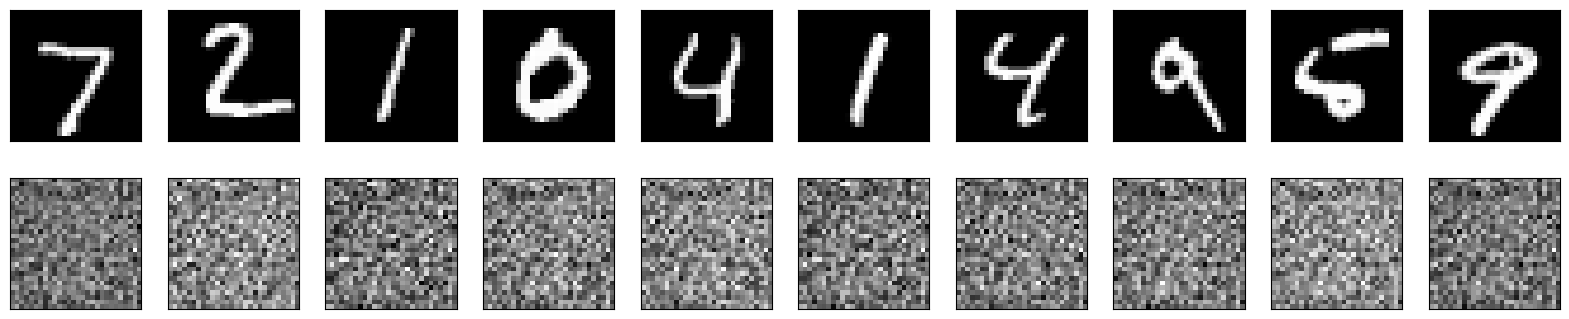

In [11]:
# now using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [12]:
ENCODING_DIM = 32

input_img = tf.keras.layers.Input(shape=(784,))

# add a dense layer with L1 activity regularizer
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# now let's train this for 100 epochs (with added regularization, the model is less likely to overfit and can be trained longer). The model ends with a train loss of 0.11 and test loss of 0.10. The difference is mostly due to the regularization term being added to the loss during training
autoencoder.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 6s 14ms/step - loss: 0.6942 - val_loss: 0.6942
Epoch 2/100
235/235 [==============================] - 3s 12ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 3/100
235/235 [==============================] - 3s 12ms/step - loss: 0.6939 - val_loss: 0.6939
Epoch 4/100
235/235 [==============================] - 3s 11ms/step - loss: 0.6938 - val_loss: 0.6938
Epoch 5/100
235/235 [==============================] - 3s 11ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 6/100
235/235 [==============================] - 3s 11ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 7/100
235/235 [==============================] - 2s 11ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/100
235/235 [==============================] - 3s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/100
235/235 [==============================] - 3s 11ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 10/100
235/235 [==============================] - 2s 9ms/step - loss: 0.6929

235/235 [==============================] - 3s 11ms/step - loss: 0.6766 - val_loss: 0.6763
Epoch 81/100
235/235 [==============================] - 3s 12ms/step - loss: 0.6762 - val_loss: 0.6758
Epoch 82/100
235/235 [==============================] - 4s 17ms/step - loss: 0.6757 - val_loss: 0.6753
Epoch 83/100
235/235 [==============================] - 4s 15ms/step - loss: 0.6752 - val_loss: 0.6748
Epoch 84/100
235/235 [==============================] - 3s 12ms/step - loss: 0.6747 - val_loss: 0.6743
Epoch 85/100
235/235 [==============================] - 4s 15ms/step - loss: 0.6741 - val_loss: 0.6738
Epoch 86/100
235/235 [==============================] - 4s 17ms/step - loss: 0.6736 - val_loss: 0.6732
Epoch 87/100
235/235 [==============================] - 3s 12ms/step - loss: 0.6730 - val_loss: 0.6726
Epoch 88/100
235/235 [==============================] - 3s 11ms/step - loss: 0.6725 - val_loss: 0.6720
Epoch 89/100
235/235 [==============================] - 3s 13ms/step - loss: 0.6719 - 

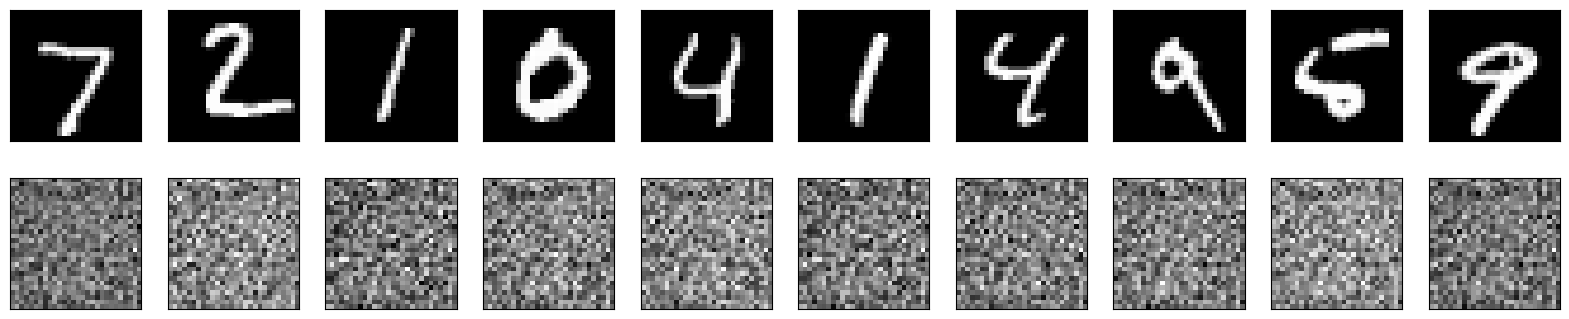

In [13]:
# now using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [14]:
input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)

decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

In [15]:
# let's try this
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 8s 20ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 2/100
235/235 [==============================] - 4s 17ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 3/100
235/235 [==============================] - 4s 16ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 4/100
235/235 [==============================] - 3s 15ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 5/100
235/235 [==============================] - 4s 15ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 6/100
235/235 [==============================] - 3s 15ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 7/100
235/235 [==============================] - 3s 15ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 8/100
235/235 [==============================] - 4s 15ms/step - loss: 0.6923 - val_loss: 0.6923
Epoch 9/100
235/235 [==============================] - 4s 15ms/step - loss: 0.6922 - val_loss: 0.6922
Epoch 10/100
235/235 [==============================] - 3s 15ms/step - loss: 0.692

235/235 [==============================] - 4s 17ms/step - loss: 0.6815 - val_loss: 0.6813
Epoch 81/100
235/235 [==============================] - 3s 14ms/step - loss: 0.6812 - val_loss: 0.6810
Epoch 82/100
235/235 [==============================] - 4s 16ms/step - loss: 0.6809 - val_loss: 0.6806
Epoch 83/100
235/235 [==============================] - 3s 14ms/step - loss: 0.6805 - val_loss: 0.6803
Epoch 84/100
235/235 [==============================] - 3s 15ms/step - loss: 0.6802 - val_loss: 0.6799
Epoch 85/100
235/235 [==============================] - 4s 17ms/step - loss: 0.6798 - val_loss: 0.6795
Epoch 86/100
235/235 [==============================] - 4s 15ms/step - loss: 0.6794 - val_loss: 0.6791
Epoch 87/100
235/235 [==============================] - 4s 19ms/step - loss: 0.6790 - val_loss: 0.6787
Epoch 88/100
235/235 [==============================] - 4s 17ms/step - loss: 0.6785 - val_loss: 0.6782
Epoch 89/100
235/235 [==============================] - 3s 15ms/step - loss: 0.6781 - 

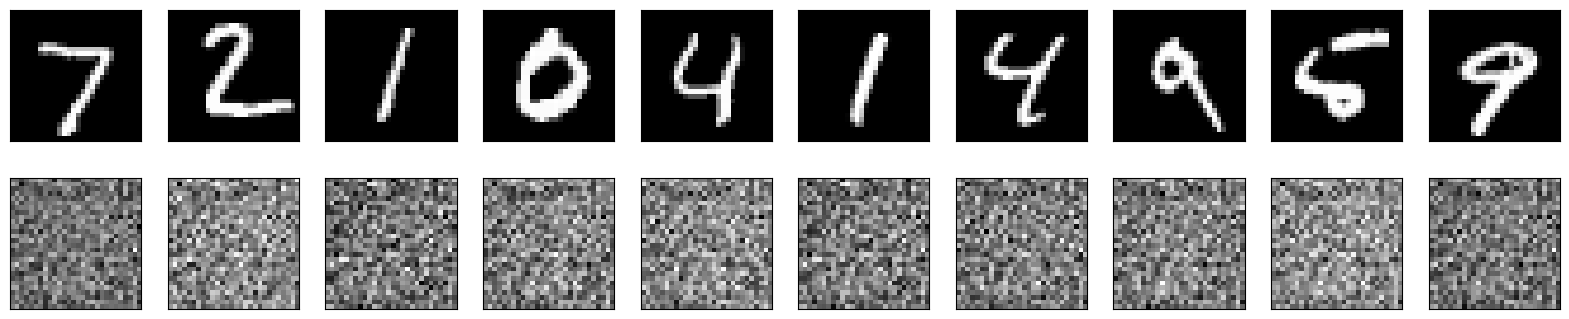

In [17]:
# now using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [18]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

In [19]:
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [21]:
# to train this model we will with original MNIST digits with shape (samples, 3, 28, 28) and we will just normalize pixel values between 0 and 1
(x_train, _), (x_test, _) = load_data('mnist.npz')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [22]:
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test), callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 60s 116ms/step - loss: 0.6798 - val_loss: 0.6763
Epoch 2/50
469/469 [==============================] - 53s 114ms/step - loss: 0.6706 - val_loss: 0.6636
Epoch 3/50
469/469 [==============================] - 52s 112ms/step - loss: 0.6522 - val_loss: 0.6378
Epoch 4/50
469/469 [==============================] - 52s 112ms/step - loss: 0.6126 - val_loss: 0.5805
Epoch 5/50
469/469 [==============================] - 52s 111ms/step - loss: 0.5360 - val_loss: 0.4982
Epoch 6/50
469/469 [==============================] - 53s 113ms/step - loss: 0.4788 - val_loss: 0.4722
Epoch 7/50
469/469 [==============================] - 53s 113ms/step - loss: 0.4626 - val_loss: 0.4601
Epoch 8/50
469/469 [==============================] - 51s 109ms/step - loss: 0.4504 - val_loss: 0.4474
Epoch 9/50
469/469 [==============================] - 50s 107ms/step - loss: 0.4372 - val_loss: 0.4332
Epoch 10/50
469/469 [==============================] - 51s 109ms/step - l

313/313 [==============================] - 7s 22ms/step


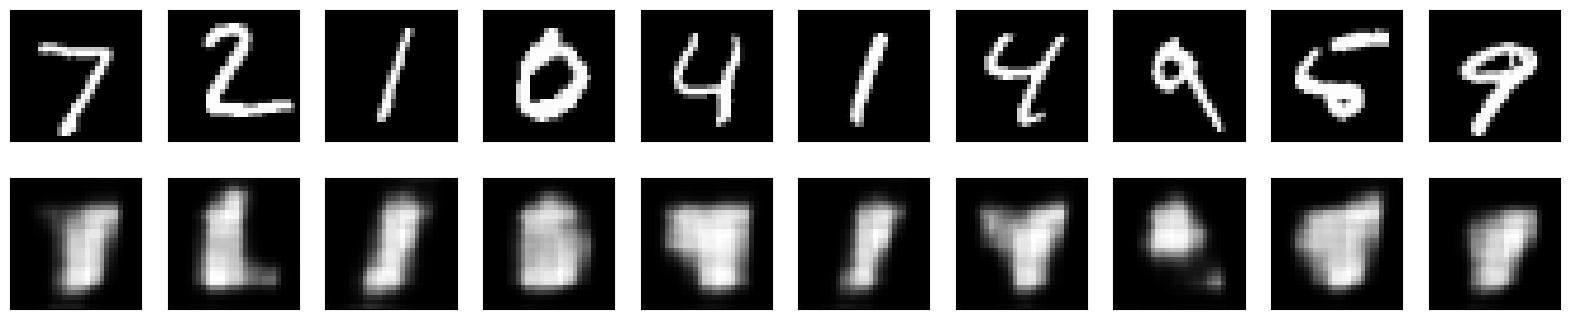

In [23]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [26]:
# to train this model we will with original MNIST digits with shape (samples, 3, 28, 28) and we will just normalize pixel values between 0 and 1
(x_train, _), (x_test, _) = load_data('mnist.npz')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test), callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 60s 117ms/step - loss: 0.7077 - val_loss: 0.7035
Epoch 2/50
469/469 [==============================] - 53s 113ms/step - loss: 0.6993 - val_loss: 0.6949
Epoch 3/50
469/469 [==============================] - 54s 115ms/step - loss: 0.6896 - val_loss: 0.6835
Epoch 4/50
469/469 [==============================] - 53s 113ms/step - loss: 0.6725 - val_loss: 0.6570
Epoch 5/50
469/469 [==============================] - 52s 112ms/step - loss: 0.6210 - val_loss: 0.5689
Epoch 6/50
469/469 [==============================] - 53s 112ms/step - loss: 0.5173 - val_loss: 0.4946
Epoch 7/50
469/469 [==============================] - 53s 113ms/step - loss: 0.4840 - val_loss: 0.4811
Epoch 8/50
469/469 [==============================] - 53s 112ms/step - loss: 0.4721 - val_loss: 0.4703
Epoch 9/50
469/469 [==============================] - 53s 113ms/step - loss: 0.4622 - val_loss: 0.4610
Epoch 10/50
469/469 [==============================] - 52s 112ms/step - l

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
